# My Plastic Diary - Part I: Data cleaning

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import calplot
import numpy as np
from scipy import stats #for streamgraph
import seaborn as sns
import pickle

%matplotlib inline

None


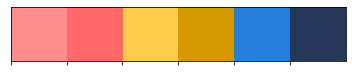

In [2]:
#set brand colours
cols = ["#ff8d8d",  "#ff6768", "#ffcd4b", "#d59a00", "#2580de", "#263859" ]
print(sns.palplot(cols))

In [2]:
# set root folder
root = os.path.abspath(os.path.join(os.getcwd(), ".."))

#load data
data = pd.read_csv(os.path.join(root, "data\\lisa_plastic_records_history.csv"))

# Data cleaning

In [3]:
#create empty dataframe
df = pd.DataFrame(columns=data.columns)

#append number of rows from original dataframe depending on quantity of item recorded
for i in range(len(data)):
    quantity = 1
    while quantity <= data["quantity"][i]:     
        df.loc[len(df.index)] = data.loc[i]
        quantity+=1
        
#set quantity as 1 for each row
df["quantity"] = 1

In [4]:
# derive date columns
df["date"] = pd.to_datetime(pd.to_datetime(df["record_created"]).dt.date)
df["weekday"] = df["date"].dt.day_name()
df["weekday_group"] = ["weekend" if x == "Sunday" else "weekend" 
                       if x == "Saturday" else "weekday" for x in df["weekday"]]

In [5]:
#use data from 2022 for missing days in January 2021
df.loc[df["date"]== pd.to_datetime("2022-01-01"), "date"] = pd.to_datetime("2021-01-01")
df.loc[df["date"]== pd.to_datetime("2022-01-02"), "date"] = pd.to_datetime("2021-01-02")
df.loc[df["date"]== pd.to_datetime("2022-01-03"), "date"] = pd.to_datetime("2021-01-03")
df.loc[df["date"]== pd.to_datetime("2022-01-04"), "date"] = pd.to_datetime("2021-01-04")
df.loc[df["date"]== pd.to_datetime("2022-01-05"), "date"] = pd.to_datetime("2021-01-05")

#filter for only 2021 data
df = df[df["date"]< pd.to_datetime("2022-01-01")]

In [7]:
#clean up some of the plastic weight recorded 
#Tetra paks: 
#tetra reocorded as 20g is actually 36g but only 20% are plastic = 7g
#tetra recorded as 30g is actually 60 but only 20% are plastic = 12g
df["DV_plastic_weight"] = df["plastic_weight"]
df.loc[(df["sub_category_id"]==20004) & (df["plastic_weight"]==20), "DV_plastic_weight"] = 8
df.loc[(df["sub_category_id"]==20004) & (df["plastic_weight"]==30), "DV_plastic_weight"] = 12

In [8]:
#write to pickled file
file = os.path.join(root, "data\\lisa_plastic_records_history_clean")

with open(file, 'wb') as f:
    pickle.dump(df, f)

# Explore

Estimated plastic waste by country: https://www.science.org/doi/10.1126/sciadv.abd0288

Proportion of plastic of tetra pak: https://drinkpathwater.com/blogs/news/10-sad-truths-about-cartons-like-tetra-pak®-why-they-are-not-a-sustainable-solution-for-bottled-water

In [13]:
print("total plastic wasted per person")
print("> per year:", round(df["DV_plastic_weight"].sum() / 2 / 1000, 1),"kg")
print("> per day:", round(df["DV_plastic_weight"].sum() / 2 / 365, 1),"g")

total plastic wasted per person
> per year: 16.0 kg
> per day: 43.7 g


In [14]:
17569/10

1756.9

## Weight per day

array([<AxesSubplot:>], dtype=object)

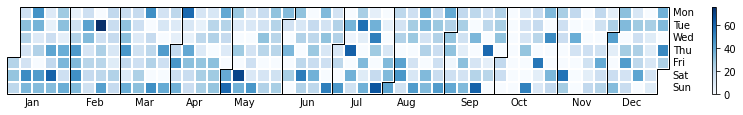

In [15]:
all_days = pd.date_range('1/1/2021', periods=365, freq='D')

events = df.groupby("date")["score"].sum()
events = pd.Series(events, index=all_days)
fig = calplot.calplot(events, cmap='Blues', yearlabels=False, edgecolor = 'black')

fig[1]

## Overview per month

In [51]:
month_dict = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 
              10: "Oct", 11: "Nov", 12:"Dec"}

In [53]:
pivot = df.groupby(df["date"].dt.month).agg({"quantity":"sum", "DV_plastic_weight":"sum", 
                                             "date": "nunique"}).rename(columns={"date":"no_days"})
#pivot.loc["Average"] = pivot.mean()
pivot = pivot.reset_index()
pivot["month"] = pivot["date"].map(month_dict)
pivot

,date,quantity,DV_plastic_weight,no_days,month
0,1,266,3301,30,Jan
1,2,254,3060,27,Feb
2,3,229,2585,27,Mar
3,4,209,2873,28,Apr
4,5,219,2948,26,May
5,6,206,2717,24,Jun
6,7,246,2988,24,Jul
7,8,248,3038,28,Aug
8,9,212,2585,25,Sep
9,10,136,1750,17,Oct


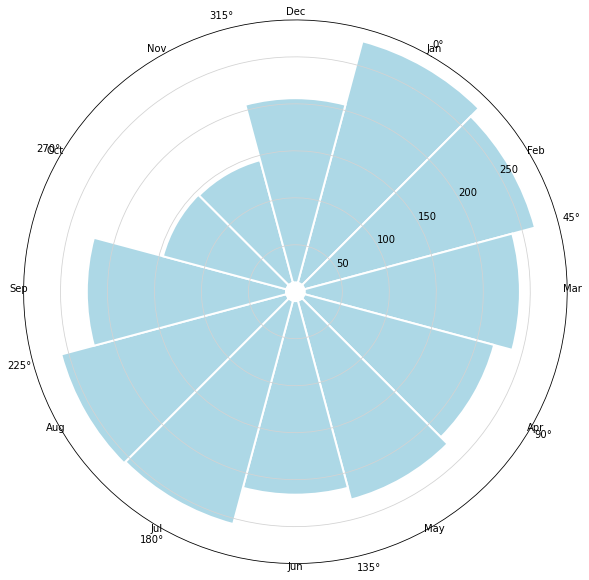

In [115]:
# =========
# Initialise Figure and define layout
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

#data
n_points = 12
inner_radius = 10
bar1 = pivot["quantity"]

x_max = 2*np.pi
x_coords = np.linspace(0, x_max, n_points, endpoint=False)
width = x_max / n_points

#add bars
ax.bar(
    x_coords,
    bar1,
    width=width,
    bottom=inner_radius,
    color="lightblue",
    edgecolor="white",
    linewidth=2
)

#add value labels and categories
for i in range(n_points):
    ax.text(x_coords[i], 295, pivot["month"][i], ha="center")
    #ax.text(x_coords[i], bar1[i]-10, bar1[i], ha="center", va='center')

#configure theta location and direction
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

#ax.get_yaxis(visible=False)
ax.grid(visible=False, axis='x', zorder=1, color = "#D3D3D3")
ax.grid(visible=True, axis='y', zorder=1, color = "#D3D3D3")

ax.set_rticks([50,100,150, 200, 250])  # Less radial ticks
ax.set_rlabel_position(360/12)
ax.set_theta_offset(np.pi / 3.0)

#ax.axis('off')
plt.show()

### Weight and items per month and category

In [39]:
pivot = df.groupby([df["date"].dt.month, "category_name"]).agg({"quantity":"sum", "DV_plastic_weight":"sum"})
pivot.unstack()

quantity                                            \
category_name Bags and film Bottles Cupboard and Hygiene Drinks Other   
date                                                                    
1                     105.0    55.0                  9.0    2.0  28.0   
2                      77.0    32.0                  5.0    6.0  70.0   
3                      87.0    35.0                  4.0    6.0  47.0   
4                      86.0    32.0                  9.0    4.0  23.0   
5                      84.0    34.0                  7.0    5.0  21.0   
6                      74.0    32.0                  7.0    1.0  43.0   
7                      94.0    45.0                  4.0    8.0  43.0   
8                     100.0    43.0                  8.0    8.0  27.0   
9                      84.0    36.0                  7.0    6.0  29.0   
10                     60.0    32.0                  1.0    NaN   7.0   
11                     69.0    34.0                  1.0    NaN   2.0   
12                     91.0    40.0                  7.0    4.0  13.0   

                                DV_plastic_weight          \
category_name Pots, tubs, trays     Bags and film Bottles   
date                                                        
1                          67.0             769.0  1006.0   
2                          64.0             541.0   796.0   
3                          50.0             578.0   817.0   
4                          55.0             584.0   768.0   
5                          68.0             479.0   893.0   
6                          49.0             408.0   956.0   
7                          52.0             501.0  1318.0   
8                          62.0             556.0  1012.0   
9                          50.0             447.0   924.0   
10                         36.0             365.0   706.0   
11                         29.0             395.0   646.0   
12                         41.0             473.0   865.0   

                                                                    
category_name Cupboard and Hygiene Drinks  Other Pots, tubs, trays  
date                                                                
1                            273.0    2.0  118.0            1133.0  
2                            212.0   10.0  349.0            1152.0  
3                            272.0   12.0   47.0             859.0  
4                            391.0    4.0   58.0            1068.0  
5                            401.0    5.0   35.0            1135.0  
6                            358.0    1.0   57.0             937.0  
7                            199.0    8.0  136.0             826.0  
8                            365.0    8.0   27.0            1070.0  
9                            342.0    6.0   90.0             776.0  
10                            29.0    NaN    7.0             643.0  
11                            70.0    NaN   11.0             520.0  
12                           368.0    6.0   33.0             702.0

In [36]:
pivot = df.groupby(df["date"].dt.month).agg({"quantity":"sum", "DV_plastic_weight":"sum", "date": "nunique"})
pivot.loc["Average"] = pivot.mean()

pivot

,quantity,DV_plastic_weight,date
date,,,
1,266.0,3301.000000,30.000000
2,254.0,3060.000000,27.000000
3,229.0,2585.000000,27.000000
4,209.0,2873.000000,28.000000
5,219.0,2948.000000,26.000000
6,206.0,2717.000000,24.000000
7,246.0,2988.000000,24.000000
8,248.0,3038.000000,28.000000
9,212.0,2585.000000,25.000000


## Proportion streamgraph - total weight

In [18]:
pivot = df.groupby(['date', 'category_name'])['plastic_weight'].sum().unstack()

#get day of year
pivot = pivot.reset_index()
pivot["doy"] = pivot["date"].dt.dayofyear

# create empty dataframe with all day of year
pivot2 = pd.DataFrame(index=np.arange(1,366)).reset_index()

#merge both
pivot = pd.merge(pivot2, pivot, left_on='index', right_on='doy', how='left')

#remove columns
pivot = pivot.drop(columns=["doy", "date"]).rename(columns={"index": "day"})

#set index
pivot = pivot.set_index(["day"])

#7-day rolling average
pivot = pivot.fillna(0)
pivot = pivot.rolling( 7).mean().shift(0)
pivot = pivot.fillna(0)

findfont: Font family ['Oswald'] not found. Falling back to DejaVu Sans.


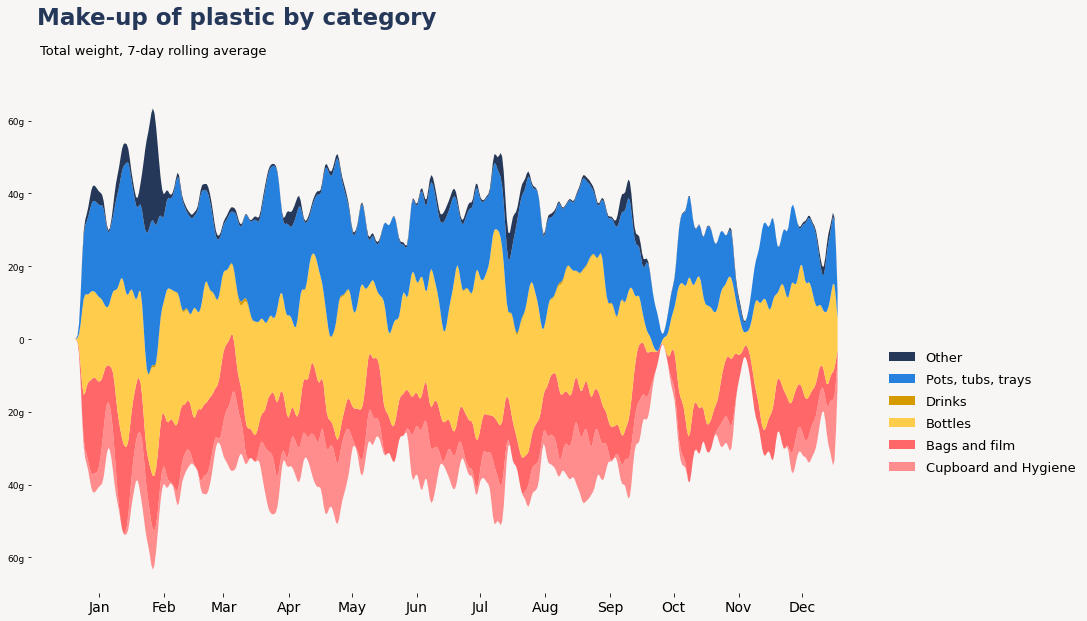

In [19]:
# =========================
# Create chart area

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)

#remove chart area frame
ax.set_frame_on(False)
#ax.set_facecolor("#f7f6f4") # change chart background colour to white

#set background colour for whole viz
fig.set_facecolor("#f7f6f4")

#remove y-axis
ax.axes.get_yaxis().set_visible(True)

# =======
#input data

#days
x = np.arange(1, 366) 

# y-values to map
columns = ['Cupboard and Hygiene','Bags and film', 'Bottles', 'Drinks','Pots, tubs, trays', 'Other'] 
y = [pivot[column].tolist() for column in columns]


# =======
# Look of streamgraph

#smooth lines 
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

#define colours
#colours = ["#ff8d8d",  "#ff6768", "#ffcd4b", "#d59a00", "#74aeea", "#2580de","#263859", "#6b778d"]

# =======
# Add title and subtitle
plt.suptitle("Make-up of plastic by category", 
             size=23, y=1.06, ha='left', x=0.03, fontweight='bold', color=cols[-1],
            fontfamily='Oswald')


plt.title("Total weight, 7-day rolling average", 
          size=13, y=1.05, ha='left', x=0.01)

# =======
# display chart


grid = np.linspace(1, 366, num=500)
#print(grid)
y_smoothed = [gaussian_smooth(x, y_, grid, 1) for y_ in y]
ax.stackplot(grid, y_smoothed, colors = cols, baseline="sym", labels=columns);

#y-axis
plt.yticks([-60, -40, -20, 0, 20, 40, 60], 
           ["60g", "40g", "20g", "0", "20g","40g", "60g"], fontsize=9)


#x-axis tickmarks
dates = ["2021-01-15", "2021-02-15",  "2021-03-15",  "2021-04-15",  "2021-05-15",  "2021-06-15",  "2021-07-15",
         "2021-08-15",  "2021-09-15",  "2021-10-15",  "2021-11-15",  "2021-12-15"]
dates = pd.DataFrame(pd.to_datetime(dates), columns=["date"])
dates["doy"] = dates["date"].dt.dayofyear
plt.xticks(dates["doy"].to_list(), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=14)

#===========
#add legend in reverse order to match chart

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [5,4,3,2,1,0]

#add legend to plot

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
            bbox_to_anchor=(1.25,0.5), frameon=False, labelspacing=0.7, fontsize=13, loc='upper right')